In [1]:
import sys
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split


# For audio and MIDI processing
import pretty_midi
import IPython

# Import this project modules
REPO_ROOT = Path('.').resolve().parent
if REPO_ROOT not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
from src.data.dataset import PianoMmapDataset, MidiPreprocessor
from src.utils.visualization import display_prettymidi
from src.utils.tools import piano_roll_to_pretty_midi

pl.seed_everything(42)

Seed set to 42


42

In [2]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size

        # --- Generator part ---
        # Fully connected layers
        self.ff_nets = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=1024),
            nn.BatchNorm1d(num_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
        )
        # Reshape layer (512 x 1 -> 256 x 1 x 2)
        self.reshape = nn.Unflatten(dim=1, unflattened_size=(256, 1, 2))
        # Transposed convolutional layers
        self.transp_conv_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(1, 2), stride=(1, 2)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.transp_conv_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(1, 2), stride=(1, 2)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.transp_conv_3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(1, 2), stride=(1, 2)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.transp_conv_4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=1, kernel_size=(128, 1), stride=1),
            nn.Sigmoid() # Output values between 0 and 1
        )

        # --- Conditioner part ---
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=256, kernel_size=(128, 1), stride=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU()
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1, 2), stride=(1, 2)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU()
        )
        self.conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1, 2), stride=(1, 2)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU()
        )
        self.conv_4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1, 2), stride=(1, 2)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU()
        )

    def forward(self, z, condition_matrix):
        # Conditioner process condition_matrix
        condition_step1 = self.conv_1(condition_matrix)
        condition_step2 = self.conv_2(condition_step1)
        condition_step3 = self.conv_3(condition_step2)
        condition_step4 = self.conv_4(condition_step3)

        # Generator process noise
        linear_output = self.ff_nets(z)
        reshaped_output = self.reshape(linear_output)
        
        # Generator Step 1: Input (Gen Start) + Condition (End)
        merged1 = torch.cat((reshaped_output, condition_step4), dim=1)
        output_step1 = self.transp_conv_1(merged1)
        # Generator Step 2: Input (Previous Output) + Condition (Previous Step)
        merged2 = torch.cat((output_step1, condition_step3), dim=1)
        output_step2 = self.transp_conv_2(merged2)
        # Generator Step 3: Input (Previous Output) + Condition (Previous Step)
        merged3 = torch.cat((output_step2, condition_step2), dim=1)
        output_step3 = self.transp_conv_3(merged3)
        # Generator Step 4: Input (Previous Output) + Condition (First Step)
        merged4 = torch.cat((output_step3, condition_step1), dim=1)
        output_step4 = self.transp_conv_4(merged4)
        
        return output_step4

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.first_conv = nn.Conv2d(in_channels=1, out_channels=14, kernel_size=(128, 2), stride=(1, 2)) # Separated by the other for the feature matching technique
        self.conv_layers = nn.Sequential(
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=14, out_channels=77, kernel_size=(1, 4), stride=(1, 2)),
            nn.BatchNorm2d(77),
            nn.LeakyReLU()
        )
        # Flatten layer
        self.flatten = nn.Flatten()
        # Feedforward layers
        self.ff_layers = nn.Sequential(
            nn.Linear(in_features=77*3, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(in_features=1024, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        f = self.first_conv(x)
        out_conv = self.conv_layers(f)
        out_flat = self.flatten(out_conv)
        output = self.ff_layers(out_flat)
        return output, f

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

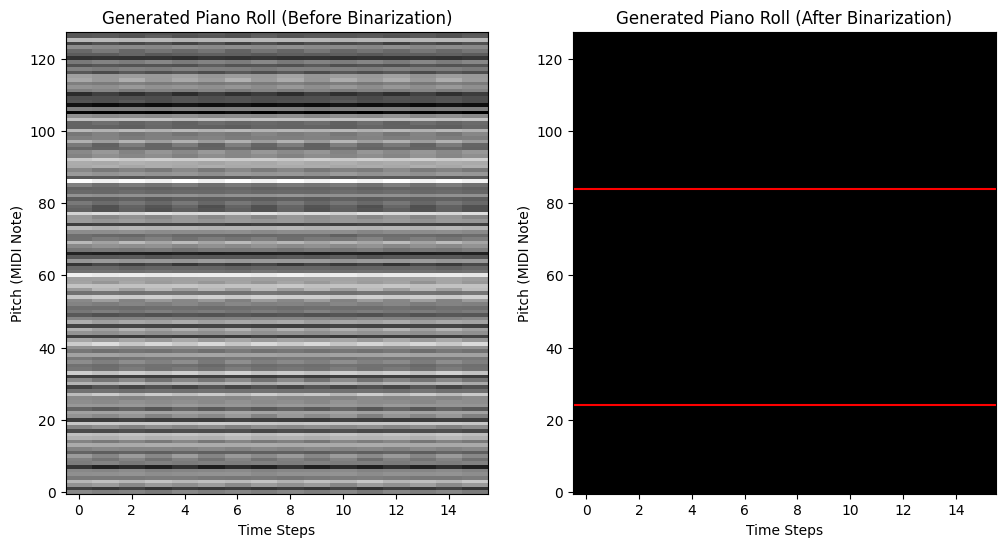

C:\Users\Andrea\Documents\Università\Magistrale\Deeplearning\NNDL-project\src\utils\visualization.py:29: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(


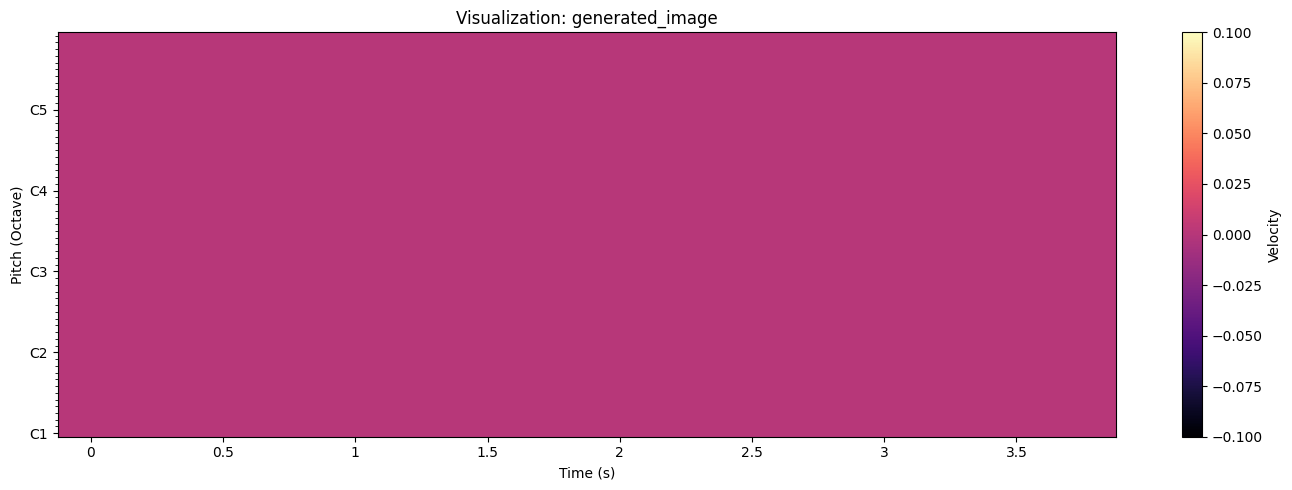

ValueError: zero-size array to reduction operation maximum which has no identity

In [5]:
generator = Generator(100)
generator.apply(weights_init)

generator.eval()
noise = torch.normal(0, 1, [1, 100]) # Batch size 1, noise dim 100
condition = torch.zeros([1, 1, 128, 16]) # Batch size 1, 1 channel, 128 notes, 16 time frames
generated_image = generator(noise, condition).detach().cpu()

# Process generated_image for visualization
generated_image = generated_image

# binarize the generated image and scale to 0-100 
b_generated_image = (generated_image.squeeze().numpy() > 0.51).astype(float) * 100

# subplot to visualize the generated piano roll previusly binarization and after
plt.subplots(1, 2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(generated_image.squeeze().numpy(), cmap='gray', aspect='auto', interpolation='nearest', origin='lower')
plt.title("Generated Piano Roll (Before Binarization)")
plt.xlabel("Time Steps")
plt.ylabel("Pitch (MIDI Note)")
plt.subplot(1, 2, 2)
plt.imshow(b_generated_image, cmap='gray', aspect='auto', interpolation='nearest', origin='lower')
plt.axhline(y=24, color='r', linestyle='-')
plt.axhline(y=84, color='r', linestyle='-')
plt.title("Generated Piano Roll (After Binarization)")
plt.xlabel("Time Steps")
plt.ylabel("Pitch (MIDI Note)")
plt.show()

# Generate PrettyMIDI object from the binarized piano roll
generated_pm = piano_roll_to_pretty_midi(b_generated_image, fs=4)
display_prettymidi(
    generated_pm, 
    fs=4, 
    pitch_range=(24, 84),
    title=f"Visualization: generated_image"
)
audio = IPython.display.Audio(generated_pm.fluidsynth(fs=16000), rate=16000)
IPython.display.display(audio)

In [6]:
discriminator = Discriminator()
discriminator.apply(weights_init)

discriminator.eval()
output, f = discriminator(generated_image)

print(output.cpu())
print(f.cpu().shape)

tensor([[0.4904]], grad_fn=<SigmoidBackward0>)
torch.Size([1, 14, 1, 8])


$\frac{1}{m}\sum_{i=1}^{m}-[\log(D(\boldsymbol{x}^{(i)})) +\log(1-D(G(\boldsymbol{z}^{(i)})))]$

In [15]:
cross_entropy = nn.BCEWithLogitsLoss()

def discriminator_loss(real_output, fake_output, device):
    ############################ CODE HERE ###############################
    real_loss = cross_entropy(real_output, torch.ones_like(real_output, device=device))
    fake_loss = cross_entropy(fake_output, torch.zeros_like(fake_output, device=device))
    total_loss = real_loss + fake_loss
    ############################ CODE HERE ###############################
    return total_loss

$\frac{1}{m}\sum_{i=1}^{m}-\log(D(G(\boldsymbol{z}^{(i)})))$

In [25]:
def generator_loss(fake_output, device):
    ############################ CODE HERE ###############################
    gen_loss = cross_entropy(fake_output, torch.ones_like(fake_output, device=device))
    ############################ CODE HERE ###############################
    return gen_loss

In [38]:
def train_step(prev_bars, curr_bars, generator, discriminator, noise_dim, device, dis_opt, gen_opt):
    BATCH_SIZE = prev_bars.shape[0]

    noise = torch.randn([BATCH_SIZE, noise_dim], device=device)

    # print(f"noise.shape: {noise.shape}")

    generated_bars = generator(noise, prev_bars)

    # print(f"generated_bars.shape: {generated_bars.shape}")

    real_output, _ = discriminator(curr_bars)
    fake_output, _ = discriminator(generated_bars.detach()) # detach to avoid backprop to generator

    # print(f"real_output.shape: {real_output.shape}")
    # print(f"fake_output.shape: {fake_output.shape}")

    disc_loss = discriminator_loss(real_output, fake_output, device)
    dis_opt.zero_grad()
    disc_loss.backward()
    dis_opt.step()

    fake_output, _ = discriminator(generated_bars)
    gen_loss = generator_loss(fake_output, device)
    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()
    return gen_loss, disc_loss

def train(dataloader, epochs, generator, discriminator, BATCH_SIZE, noise_dim, device, dis_opt, gen_opt):
  gloss = []
  dloss = []
  
  for epoch in range(epochs):
    start = time.time()

    gen_losses = []
    disc_losses = []

    for prev_bars, curr_bars in dataloader:
        
        # prev_bars, curr_bars of shape (BATCH_SIZE, 1, 128, 16)
        prev_bars, curr_bars = prev_bars.to(device), curr_bars.to(device)

        gen_loss, disc_loss = train_step(prev_bars, curr_bars, generator, discriminator, noise_dim, device, dis_opt, gen_opt)

        gen_losses.append(gen_loss.detach().cpu())
        disc_losses.append(disc_loss.detach().cpu())
              
    gloss.append(np.mean(gen_losses))
    dloss.append(np.mean(disc_losses))

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print('Generator loss: {}, Discriminator loss: {}'.format(gloss[-1], dloss[-1]))
    
  return gloss, dloss

In [ ]:
discriminator = Discriminator()
discriminator.apply(weights_init)

gen_opt = torch.optim.Adam(generator.parameters(), lr=2e-4)
dis_opt = torch.optim.Adam(discriminator.parameters(), lr=2e-4)

EPOCHS = 30

device = torch.device("cuda")

generator.to(device)
discriminator.to(device)

processing_results_path = REPO_ROOT / 'data' / 'processing_results_details.txt'
mmap_path = REPO_ROOT / 'data' / 'piano_dataset.dat'

try:
    with open(processing_results_path, 'r') as f:
        while True:
            line = f.readline()
            if not line:
                break
            if line.startswith("Total segments created:"):
                total_segments = int(line.strip().split(":")[-1])
                break
except FileNotFoundError:
    print(f"File not found: {processing_results_path}")

all_indices = np.arange(total_segments)

# Split indices (80% Train, 10% Val, 10% Test)
train_indices, temp_indices = train_test_split(all_indices, test_size=0.2, random_state=42, shuffle=True)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42, shuffle=True)

print(f"Train Segments: {len(train_indices)}")
print(f"Val Segments:   {len(val_indices)}")
print(f"Test Segments:  {len(test_indices)}")

# Instantiate the Datasets
train_dataset = PianoMmapDataset(mmap_path, split_indices=train_indices, shape=(total_segments, 128, 128))
val_dataset   = PianoMmapDataset(mmap_path, split_indices=val_indices, shape=(total_segments, 128, 128))
test_dataset  = PianoMmapDataset(mmap_path, split_indices=test_indices, shape=(total_segments, 128, 128))

# Create the DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=72, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size=72, shuffle=False, num_workers=0)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=72, shuffle=False, num_workers=0)

gloss, dloss = train(train_loader, EPOCHS, generator, discriminator, 72, 100, device, dis_opt, gen_opt)

Train Segments: 1752
Val Segments:   219
Test Segments:  220
Time for epoch 1 is 7.013250827789307 sec
Generator loss: 0.5275490880012512, Discriminator loss: 1.3389447927474976
Time for epoch 2 is 6.768618583679199 sec
Generator loss: 0.6171604990959167, Discriminator loss: 1.1416845321655273
Time for epoch 3 is 6.719316244125366 sec
Generator loss: 0.6726451516151428, Discriminator loss: 1.0650683641433716
Time for epoch 4 is 6.880050420761108 sec
Generator loss: 0.6838724613189697, Discriminator loss: 1.0464322566986084
Time for epoch 5 is 6.938446044921875 sec
Generator loss: 0.688540518283844, Discriminator loss: 1.040289282798767
Time for epoch 6 is 6.863464593887329 sec
Generator loss: 0.6753923296928406, Discriminator loss: 1.0655109882354736
Time for epoch 7 is 6.797869682312012 sec
Generator loss: 0.6885632872581482, Discriminator loss: 1.0395746231079102
Time for epoch 8 is 6.797312021255493 sec
Generator loss: 0.6913599967956543, Discriminator loss: 1.0310795307159424
Time 

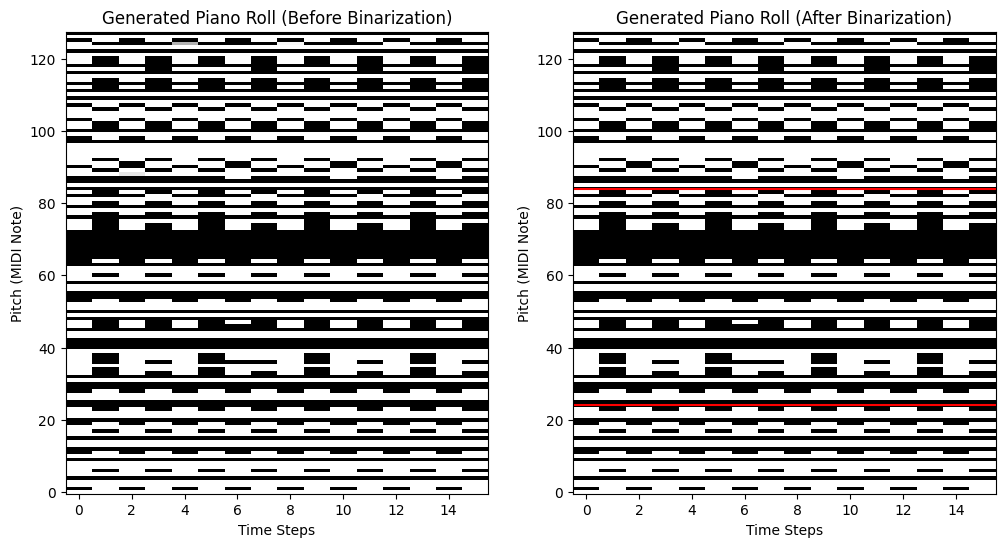

C:\Users\Andrea\Documents\Università\Magistrale\Deeplearning\NNDL-project\src\utils\visualization.py:29: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(


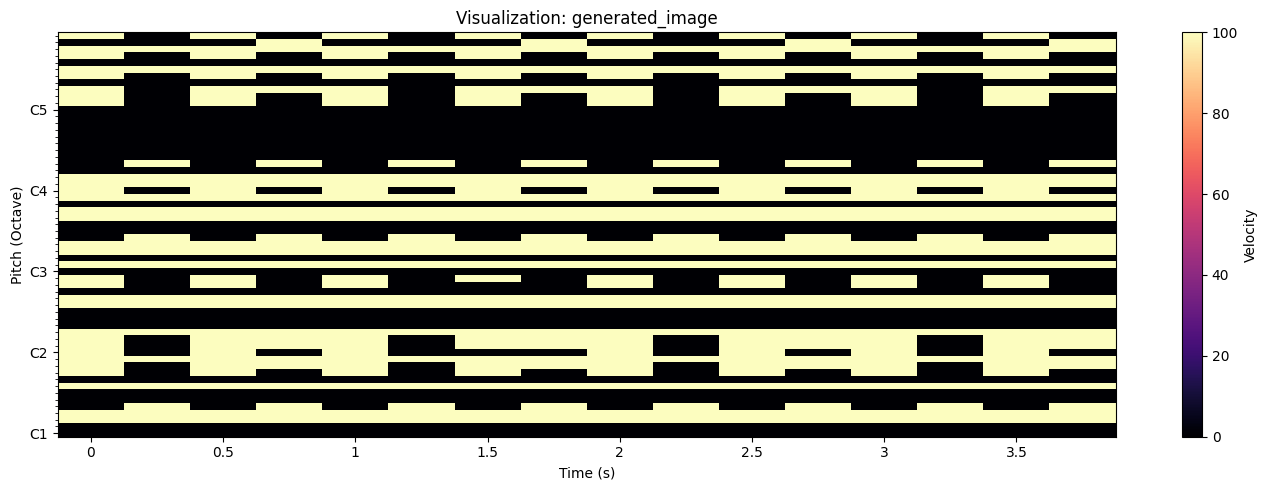

In [41]:
generator.eval()
noise = torch.normal(0, 1, [1, 100]).to(device) # Batch size 1, noise dim 100
condition = torch.zeros([1, 1, 128, 16]).to(device) # Batch size 1, 1 channel, 128 notes, 16 time frames
generated_image = generator(noise, condition).detach().cpu()

# Process generated_image for visualization
generated_image = generated_image

# binarize the generated image and scale to 0-100 
b_generated_image = (generated_image.squeeze().numpy() > 0.51).astype(float) * 100

# subplot to visualize the generated piano roll previusly binarization and after
plt.subplots(1, 2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(generated_image.squeeze().numpy(), cmap='gray', aspect='auto', interpolation='nearest', origin='lower')
plt.title("Generated Piano Roll (Before Binarization)")
plt.xlabel("Time Steps")
plt.ylabel("Pitch (MIDI Note)")
plt.subplot(1, 2, 2)
plt.imshow(b_generated_image, cmap='gray', aspect='auto', interpolation='nearest', origin='lower')
plt.axhline(y=24, color='r', linestyle='-')
plt.axhline(y=84, color='r', linestyle='-')
plt.title("Generated Piano Roll (After Binarization)")
plt.xlabel("Time Steps")
plt.ylabel("Pitch (MIDI Note)")
plt.show()

# Generate PrettyMIDI object from the binarized piano roll
generated_pm = piano_roll_to_pretty_midi(b_generated_image, fs=4)
display_prettymidi(
    generated_pm, 
    fs=4, 
    pitch_range=(24, 84),
    title=f"Visualization: generated_image"
)
audio = IPython.display.Audio(generated_pm.fluidsynth(fs=16000), rate=16000)
IPython.display.display(audio)